In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
from pprint import pformat

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colorbar as colourbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size
import matplotlib.colors as colours
from copy import copy
%matplotlib inline

from geodesic_agent import GeodesicAgent
from reward_agent import RewardAgent
from gridworld import Arena, Bottleneck, LinearChamber, GridWorld
from graph import CommunityGraph
from plot_utils import plot_replay, plot_traj, plot_need_gain, plot_state_metric
from graph_utils import betweenness_centrality, resolvent_centrality
from RL_utils import oned_twod, twod_oned

def dict_print(d, indent_size=1):
    '''
        Fancy dictionary printing. Collapse identical, consecutive rows in input dictionary d.
    '''
    indent = ' ' * indent_size
    for kdx, key in enumerate(d.keys()):
        val = d[key]
        if kdx == 0: # No previous one to compare to
            prev_val = val
            start = kdx
            continue
        
        if val == prev_val: # Consecutive, skip
            continue
        
        # Non-consecutive, print out
        if kdx - 1 == start:
            print_key = '%d' % start
        else:
            print_key = '%d-%d' % (start, kdx - 1)
        
        print(indent + '%s: %s' % (print_key, prev_val))
        
        # Update
        start = kdx
        prev_val = val
    
    if kdx - 1 == start:
        print_key = '%d' % start
    else:
        print_key = '%d-%d' % (start, kdx - 1)

    print(indent + '%s: %s' % (print_key, prev_val))
    
def plot_Tmaze_replay(replayed_experiences, width, height, gw, savename=None, overlap_adjust=0.15, ax=None):
    ''' 
        Plot replay on the T-maze. 

        Params:
            replayed_experiences (nd.array)
            width, height (int)
            gw (GridWorld)
    '''
    # Generic setup
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.set_xlim(2, width + 0.5)
    ax.set_ylim(height + 0.5, -0.5)  # Puts origin at top left
    ax.xaxis.tick_top()  # Puts x-axis ticks on top
    plt.axis('off')
    ax.set_aspect('equal')

    # Draw walls
    for wall in gw.blocked_paths:
        state, action = wall
        row, col = oned_twod(state, width, height)
        if col == width - 1 and row != 0:
            continue

        if row == height - 1 and col != width // 2:
            continue

        if action == 0:  # Block left wall
            ax.plot([col, col], [row, row + 1], color='k')
        elif action == 1:  # Block top wall
            ax.plot([col, col + 1], [row, row], color='k')
        elif action == 2:  # Block right wall
            ax.plot([col + 1, col + 1], [row, row + 1], color='k')
        else:  # Block bottom wall
            ax.plot([col, col + 1], [row + 1, row + 1], color='k')

    # Draw grid lines in the maze
    for y in range(height):
        ax.plot([width // 2, width // 2 + 1], [y, y], alpha=0.35, color='gray', linewidth=0.5)

    for x in range(width):
        ax.plot([x, x], [0, 1], alpha=0.35, color='gray', linewidth=0.5)

    # Plot the replayed experiences
    ## Now add arrows for replayed states
    # Colours!
    arrow_colours = plt.cm.winter(np.linspace(0, 1, replayed_experiences.shape[0]))
    CENTRE_OFFSET = 0.5  # oned_twod gives the coordinate of the top left corner of the state
    for i in range(replayed_experiences.shape[0]):
        # Get plotting coordinates
        start, action, successor = replayed_experiences[i, :]
        start_y, start_x = np.array(oned_twod(start, gw.width, gw.height)) + CENTRE_OFFSET
        succ_y, succ_x = np.array(oned_twod(successor, gw.width, gw.height)) + CENTRE_OFFSET
        if i == 1:
            start_x -= overlap_adjust
        if i > 1 and i <= 5:
            start_x -= overlap_adjust
            succ_x -= overlap_adjust
        if i == 9:
            start_x += overlap_adjust
        if i > 9:
            start_x += overlap_adjust
            succ_x += overlap_adjust

        # Plot
        ax.arrow(start_x, start_y, succ_x - start_x, succ_y - start_y,
                 length_includes_head=True, head_width=0.25, color=arrow_colours[i])

    # Add colour bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = colourbar.ColorbarBase(cax, cmap=plt.cm.winter, orientation='vertical', ticks=[0, 1])
    cbar.ax.set_yticklabels(['start', 'end'])
    
    if savename:
        plt.savefig(savename, transparent=True)
        
def get_fixed_size_figax(nrow, ncol, figsize=(18, 6), fhsize=5, fvsize=3.5):
    '''
        Plotting utility
    '''
    fh = Size.Fixed(fhsize)
    fv = Size.Fixed(fvsize)

    fig, axes = plt.subplots(nrow, ncol, figsize=figsize)
    h = [fh] * ncol
    v = [fv] * nrow
    divider = Divider(fig, (0.0, 0.0, 1., 1.), h, v)
    if nrow == 1 and ncol == 1:
        axes.set_axes_locator(divider.new_locator(nx=0, ny=0))
    elif nrow == 1:
        for j in range(ncol):
            axes[j].set_axes_locator(divider.new_locator(nx=j, ny=0))
    elif ncol == 1:
        for i in range(nrow):
            axes[i].set_axes_locator(divider.new_locator(nx=0, ny=i))
    else:
        for i in range(nrow):
            for j in range(ncol):
                axes[i,j].set_axes_locator(divider.new_locator(nx=j, ny=i))
                
    return fig, axes

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colours.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    
    return new_cmap


mpl.rcParams.update({'font.size': 25})
mpl.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

### Figure 1

In [4]:
# Physics
width = 10
height = 7
num_states = width * height

# Build object
one_start_state = np.zeros(num_states)
one_start_state[0] = 1
all_start_states = np.ones(num_states) / num_states
init_state_dist = one_start_state

# Set goals
corridor_end = 36 
goal = 36  # Fig 1A, Fig 1B has additional goal indices: 7, 11, 47
rvec = np.zeros(num_states)
rvec[goal] = 1 

# Build some walls
walls = [(corridor_end, 1), (corridor_end, 2), (corridor_end, 3), (corridor_end - 1, 1), (corridor_end - 1, 3), (corridor_end - 2, 1), (corridor_end - 2, 3)]
walls.extend([(corridor_end - 3, 1), (corridor_end - 3, 3)])

arena = GridWorld(width, height, init_state_distribution=init_state_dist, walls=walls, term_states=[goal])
all_experiences = arena.get_all_transitions(rvec=rvec)
T = arena.transitions

## Agent parameters
alpha = 1.0
gamma = 0.95

# Set up agent
ra = RewardAgent(arena.num_states, arena.num_actions, T, s0_dist=init_state_dist, alpha=alpha, gamma=gamma)
ra.curr_state = 0

num_steps = 10000
for t in range(num_steps):
    rand_act = np.random.choice(4)
    successor, reward = arena.step(ra.curr_state, action=rand_act, reward_vector=rvec)
    
    # Learn
    ra.basic_learn((ra.curr_state, rand_act, successor, reward))
    
    # Update
    if reward > 0:
        ra.curr_state = np.random.choice(num_states)
        while ra.curr_state == goal:
            ra.curr_state = np.random.choice(num_states)
    else:
        ra.curr_state = successor

# Get state values from Q-values
V = np.zeros(num_states)
for i in range(num_states):
    if i != goal:
        V[i] = np.max(ra.Q[i, :])
        
V[goal] = 1 # identically, the reward value

*Figure 1A/B, reward and value maps for a particular enclosure with various goal locations*

Text(0.5, 1.0, 'Value')

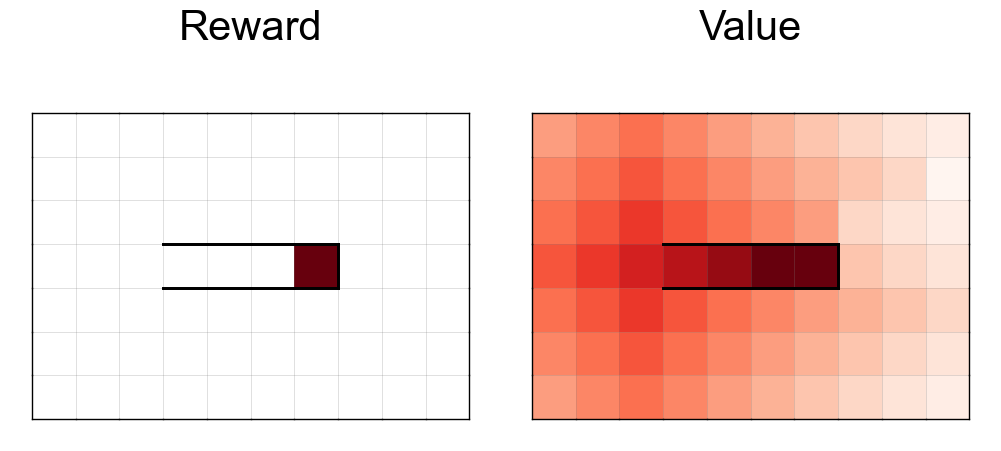

In [5]:
nrow = 1
ncol = 2
fig, axes = get_fixed_size_figax(nrow, ncol)

# Reward
ax = axes[0]
rvec = np.zeros(num_states)
rvec[goal] = 1

gridworld = arena
metric = rvec

ax.set_aspect('equal')
ax.set_axis_off()
gridworld.draw(use_reachability=True, ax=ax)

# Grab boundaries
min_metric = 0.0001  # Dumb hack so that metric = 0 states don't appear slightly red
max_metric = np.max(rvec)

metric_cols = colours.Normalize(vmin=min_metric, vmax=max_metric)(rvec)

# Build custom palette without dumb red bottom boundary
palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)

# Get colours for each state
state_colours = palette(metric_cols).reshape(-1, 4)
for state in range(gridworld.num_states):
    if hasattr(gridworld, 'banned_states') and state in gridworld.banned_states:
        continue
    row, col = oned_twod(state, gridworld.width, gridworld.height)
    rect = patches.Rectangle((col, row), 1, 1, facecolor=state_colours[state])
    ax.add_patch(rect)

ax.set_title('Reward')

# Value
ax = axes[1]
plot_state_metric(arena, V, save=False, savename='./figs/fig1/1r_walls_Qmap.pdf', wall_width=2, ax=ax)
ax.set_title('Value')

# Save
# fig.savefig('./figs/fig1/1_Qr_map.pdf', transparent=True, bbox_inches=0, pad_inches=0)

*Fig 1E, need, gain, and EVB maps for an open field environment -- before learning*

In [6]:
# Physics
width = 10
height = 7
num_states = width * height

# Build object
one_start_state = np.zeros(num_states)
one_start_state[0] = 1
all_start_states = np.ones(num_states) / num_states
init_state_dist = one_start_state

arena = Arena(width, height, init_state_distribution=init_state_dist)
all_experiences = arena.get_all_transitions()
T = arena.transitions

## Agent parameters
corner_goals = np.array([width - 1, (height - 1) * width, height * width - 1]) # Non-start corners
all_goals = np.arange(0, width * height)
goals = corner_goals

alpha = 1.0
gamma = 0.95
num_replay_steps = 1

# Set up agent
ga = GeodesicAgent(arena.num_states, arena.num_actions, goals, T, alpha=alpha, gamma=gamma,
                   s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_experiences, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
needs, trans_needs, gains, all_MEVBs = stats_for_nerds

First 1 replay steps


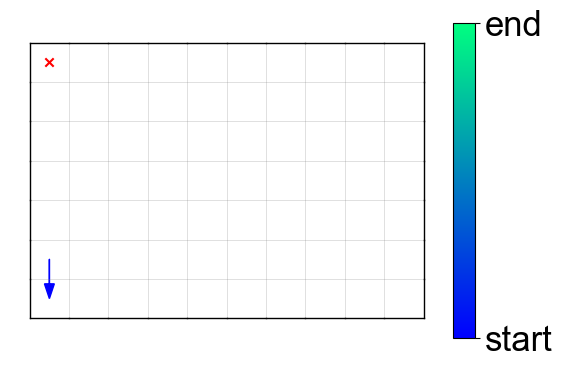

step 0:
	Replayed transition: [50  3 60]
	Backup dictionary:
        0-1: []
	Replay history:


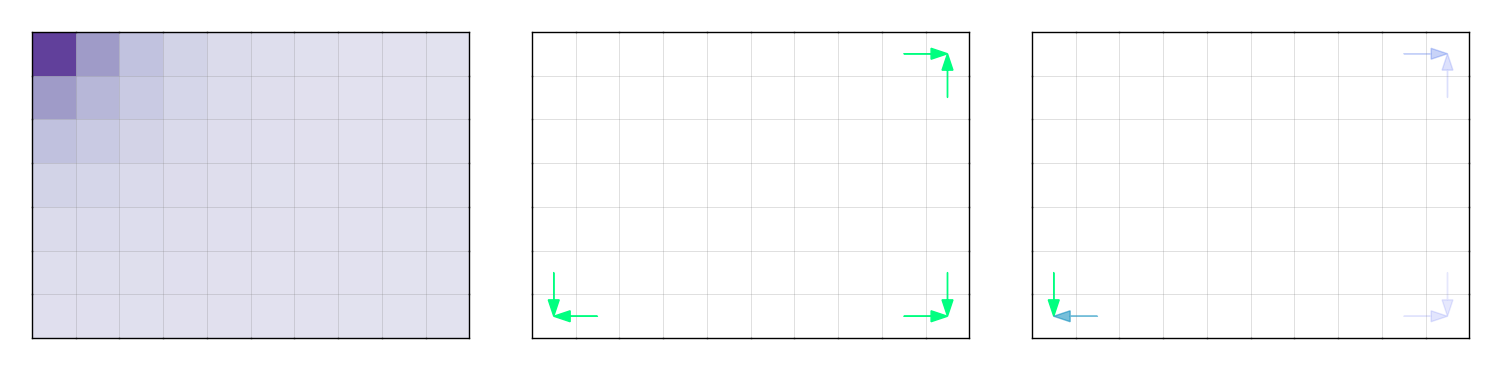

In [7]:
# Plot the replayed experiences
cmap = plt.get_cmap('Purples')
trunc_purples = truncate_colormap(cmap, 0.2, 0.8)

print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(arena, np.array(replayed_experiences).astype(int), ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.scatter(0.5, 0.5, marker='x', color='r')
plt.show()

# Plot need, gain, MEVB throughout each of those steps
meta_need = np.mean(needs, axis=1)
meta_gain = np.mean(gains, axis=1)
meta_MEVB = np.mean(all_MEVBs, axis=1)
verbose = True

fig, axes = get_fixed_size_figax(1, 3)
# for i in range(num_replay_steps):
for i in [0]:
    print('step %d:' % i)
    if verbose:
        print('\tReplayed transition:', replayed_experiences[i])
        print('\tBackup dictionary:')
        dict_print(backups[i], indent_size=8)
        print('\tReplay history:')
        for j in range(i):
            print('\t\t',replayed_experiences[j])

    plot_need_gain(arena, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
                   meta_gain[i, :], meta_MEVB[i, :], specials=None, params=None, fig=fig, axes=axes,
                   custom_need_cmap=trunc_purples)
    # plt.savefig('./figs/fig1/needgainevb_pre.pdf', transparent=True)
    plt.show()

*Fig 1E, need, gain, and EVB maps for an open field environment -- after learning*

In [8]:
# Physics
width = 10
height = 7
num_states = width * height

# Build object
one_start_state = np.zeros(num_states)
one_start_state[0] = 1
all_start_states = np.ones(num_states) / num_states
init_state_dist = one_start_state

arena = Arena(width, height, init_state_distribution=init_state_dist)
all_experiences = arena.get_all_transitions()
T = arena.transitions

## Agent parameters
corner_goals = np.array([width - 1, (height - 1) * width, height * width - 1]) # Non-start corners
all_goals = np.arange(0, width * height)
goals = corner_goals

alpha = 1.0
gamma = 0.95
num_replay_steps = 1

# Set up agent
ga = GeodesicAgent(arena.num_states, arena.num_actions, goals, T, alpha=alpha, gamma=gamma,
                   s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories
G = arena.solve_GR(10000, gamma)
ga.initialize_GR(G)

## Run replay
replayed_experiences, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, 
                                                           prospective=True, check_convergence=False)
needs, trans_needs, gains, all_MEVBs = stats_for_nerds

First 1 replay steps


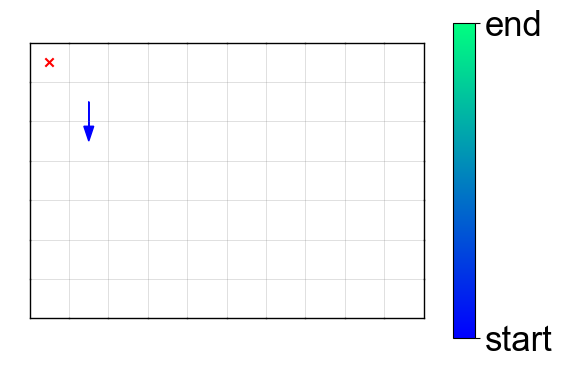

step 0:
	Replayed transition: [11  3 21]
	Backup dictionary:
        0-1: []
	Replay history:


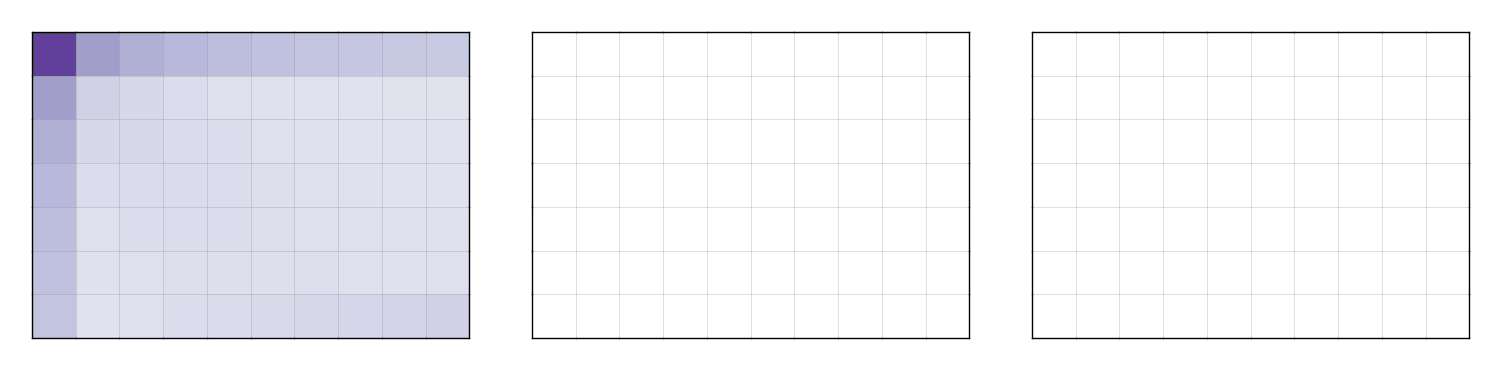

In [9]:
# Plot the replayed experiences
print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(arena, np.array(replayed_experiences).astype(int), ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
ax.scatter(0.5, 0.5, marker='x', color='r')
plt.show()

# Plot need, gain, MEVB throughout each of those steps
# zeroed_needs = zero_needs(needs, goals)
zeroed_needs = needs
meta_need = np.mean(zeroed_needs, axis=1)
meta_gain = np.mean(gains, axis=1)
meta_MEVB = np.mean(all_MEVBs, axis=1)
verbose = True

fig, axes = get_fixed_size_figax(1, 3)
# for i in range(num_replay_steps):
for i in [0]:
    print('step %d:' % i)
    if verbose:
        print('\tReplayed transition:', replayed_experiences[i])
        print('\tBackup dictionary:')
        dict_print(backups[i], indent_size=8)
        print('\tReplay history:')
        for j in range(i):
            print('\t\t',replayed_experiences[j])

    plot_need_gain(arena, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
                   meta_gain[i, :], meta_MEVB[i, :], specials=None, params=None, fig=fig, axes=axes,
                   custom_need_cmap=trunc_purples)
    # plt.savefig('./figs/fig1/needgainevb_post.pdf', transparent=True)
    plt.show()

### Figure 2A, Asymmetric T-maze

*GR*

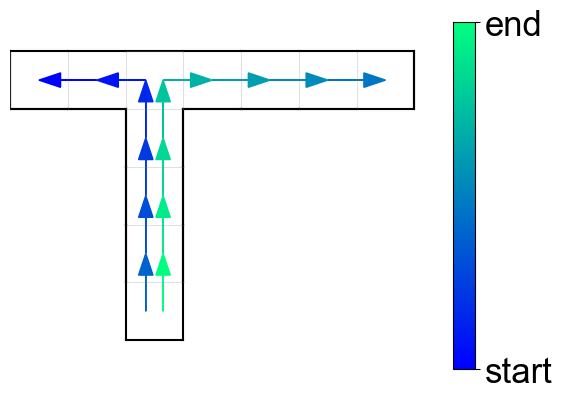

In [11]:
# Physics
height = 5
width = 9
num_states = width * height

# Special states
start = twod_oned(width // 2, height - 1, width)
choice = twod_oned(width // 2, 0, width)
near_goal = choice - 2
far_goal = choice + 4

# Build walls
walls = []
for h in range(height - 1, 0, -1):
    state_x = width // 2
    state_y = h
    state_id = twod_oned(state_x, state_y, width)

    walls.append((state_id, 0))
    walls.append((state_id, 2))

walls.append((near_goal, 0))
walls.append((far_goal, 2))

for w in range(near_goal, far_goal + 1):
    if w == width // 2:
        continue
    
    walls.append((w, 3))
    
# Build GridWorld
s0_dist = np.zeros(num_states)
s0_dist[start] = 1
gw = GridWorld(width, height, walls=walls, init_state_distribution=s0_dist)

T = gw.transitions
all_experiences = gw.get_all_transitions()

# Goal distribution
goal_dist = np.array([near_goal, far_goal])

## Agent parameters
alpha = 1.0
gamma = 0.95
num_replay_steps = 14

# Set up agent
ga = GeodesicAgent(gw.num_states, gw.num_actions, goal_dist, T, alpha=alpha, gamma=gamma,
                   s0_dist=s0_dist)
ga.curr_state = start
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_experiences, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True)
needs, trans_needs, gains, all_MEVBs = stats_for_nerds

# Plot
plot_Tmaze_replay(replayed_experiences, width, height, gw, savename='./figs/figs/Tmaze_GR_clean.pdf')

*Mattar*

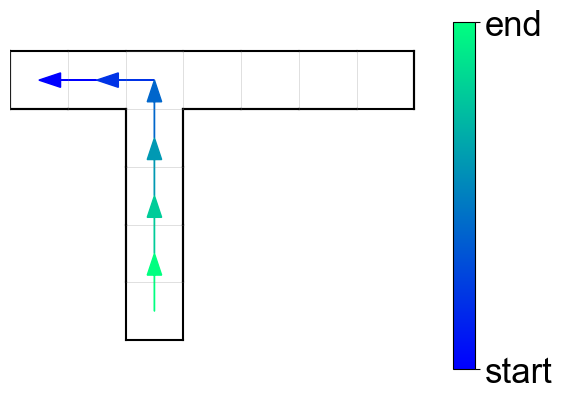

In [12]:
# Physics
height = 5
width = 9
num_states = width * height

# Special states
start = twod_oned(width // 2, height - 1, width)
choice = twod_oned(width // 2, 0, width)
near_goal = choice - 2
far_goal = choice + 4

# Build walls
walls = []
for h in range(height - 1, 0, -1):
    state_x = width // 2
    state_y = h
    state_id = twod_oned(state_x, state_y, width)

    walls.append((state_id, 0))
    walls.append((state_id, 2))

walls.append((near_goal, 0))
walls.append((far_goal, 2))

for w in range(near_goal, far_goal + 1):
    if w == width // 2:
        continue
    
    walls.append((w, 3))

# Goal distribution
rvec = np.zeros(num_states)
rvec[near_goal] = 1/2
rvec[far_goal] = 1/2

# Build GridWorld
s0_dist = np.zeros(num_states)
s0_dist[start] = 1
gw = GridWorld(width, height, walls=walls, init_state_distribution=s0_dist, term_states=[near_goal, far_goal])

T = gw.transitions
all_experiences = gw.get_all_transitions(rvec=rvec)

## Agent parameters
alpha = 1.0
gamma = 0.95
num_replay_steps = 14

## Agent parameters
alpha = 1.0
gamma = 0.95
num_replay_steps = 14

# Set up agent
ra = RewardAgent(gw.num_states, gw.num_actions, T, s0_dist=s0_dist, alpha=alpha, gamma=gamma)
ra.curr_state = start
ra.remember(all_experiences)
replays, _, _ = ra.replay(num_replay_steps, verbose=True, prospective=False, conv_thresh=1e-4)

plot_Tmaze_replay(np.array(replays[:, :3]).astype(int), width, height, gw, 
                  savename='./figs/figs/Tmaze_mattar_clean.pdf', overlap_adjust=0)

### Figure 2B, bottleneck chamber

*Figure 2B, schematic, asymptotic need, and empirical replay distribution in bottleneck chamber*

In [2]:
run_replay = False
num_sims = 200
start = 0

# Physics
room_width = 3
corridor_width = 3
width = room_width * 2 + corridor_width
height = 5
num_states = width * height

# Build object
valid_states = Bottleneck.get_valid_states(room_width, corridor_width, height)

all_states = np.zeros(num_states)
all_states[valid_states] = 1 / len(valid_states)
one_state = np.zeros(num_states)
one_state[0] = 1
init_state_dist = all_states

bottleneck = Bottleneck(room_width, corridor_width, height, init_state_distribution=init_state_dist)
all_experiences = bottleneck.get_all_transitions()
T = bottleneck.transitions

# Agent parameters
corner_goals = np.array([width - 1, height * width - 1]) # Non-start corners
all_goals = np.arange(num_states)
valid_goals = valid_states
goals = valid_goals

alpha = 1.0
gamma = 0.95
num_replay_steps = 1000

if run_replay:
    print('running...')
    for i in range(start, num_sims):
        print(i, end=', ')
        
        # Set up agent
        ga = GeodesicAgent(bottleneck.num_states, bottleneck.num_actions, goals, T, alpha=alpha, gamma=gamma,
                          s0_dist=init_state_dist)
        ga.curr_state = 0
        ga.remember(all_experiences) # Pre-load our agent with all possible memories

        ## Run replay
        replayed_exps, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
        needs, trans_needs, gains, all_MEVBs = stats_for_nerds
        np.savez('./Data/bottleneck/bottleneck_%d.npz' % i, replayed_exps=replayed_exps)
    print('ran!')

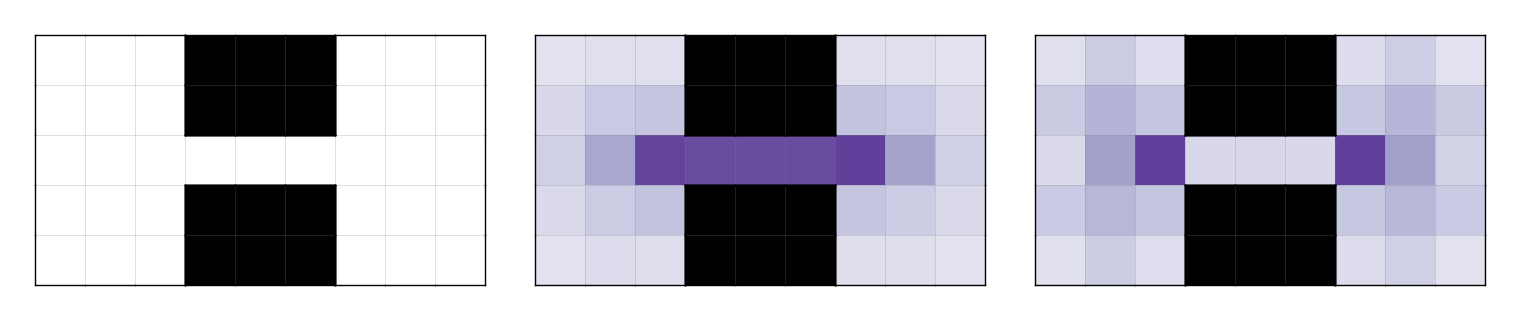

In [4]:
num_sims = 200
hmap = np.zeros((num_states, num_sims))
for sim in range(num_sims):
    d = np.load('./Data/bottleneck/bottleneck_%d.npz' % sim)
    replayed_exps = d['replayed_exps']
    meta_need = d['meta_need']
    for i in range(replayed_exps.shape[0]):
        hmap[replayed_exps[i, 0], sim] += 1

hmap_avg = np.mean(hmap, axis=1)
hmap_avg = hmap_avg.reshape(height, width)

cmap = plt.get_cmap('Purples')
trunc_cividis = truncate_colormap(cmap, 0.2, 0.8)

fig, axes = get_fixed_size_figax(nrow=1, ncol=3, figsize=(22, 6))

# Schematic
ax = axes[0]
ax.set_aspect('equal')
ax.set_axis_off()
bottleneck.draw(use_reachability=True, ax=ax, wall_width=1)

# Asymptotic need
ax = axes[1]
plot_state_metric(bottleneck, np.average(meta_need[-1, :, :], weights=init_state_dist, axis=0), save=False, ax=ax,
                 wall_width=1, custom_cmap=trunc_cividis)

# Simulated replay distribution
ax = axes[2]
plot_state_metric(bottleneck, hmap_avg.reshape(-1), save=False, ax=ax, wall_width=1, custom_cmap=trunc_cividis)

# Save
fig.savefig('./figs/Fig2_bottleneck.pdf', transparent=True)

*Supp. fig. comparison of need to betweenness-centrality in bottleneck chamber*

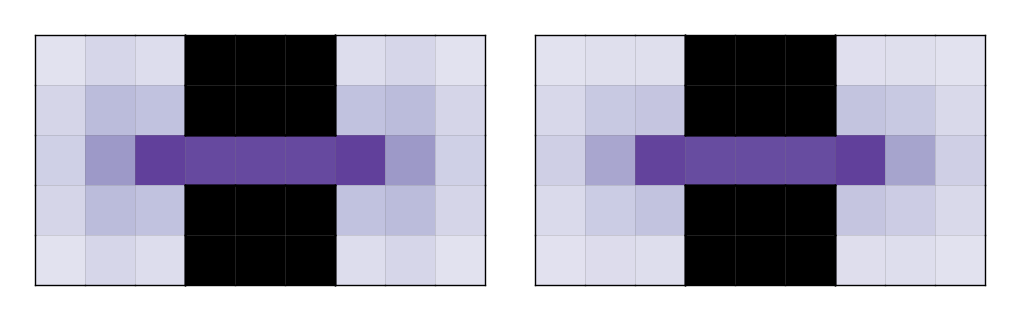

In [5]:
cmap = plt.get_cmap('Purples')
trunc_cividis = truncate_colormap(cmap, 0.2, 0.8) # plasma 0.15 1.0

fig, axes = get_fixed_size_figax(nrow=1, ncol=2, figsize=(22, 6))

# Betweenness centrality
ax = axes[0]
ax.set_aspect('equal')
ax.set_axis_off()

bottleneck_A = bottleneck.generate_adjacency_matrix(allow_self_loops=True, allow_multiloops=True)
for i in range(num_states):
    if i not in valid_states:
        bottleneck_A[i, :] = 0
        
# betweenness centrality
bc = betweenness_centrality(bottleneck_A, convert_unweighted=True)
plot_state_metric(bottleneck, bc, save=False, ax=ax,
                 wall_width=1, custom_cmap=trunc_cividis)

# Asymptotic need
ax = axes[1]
plot_state_metric(bottleneck, np.average(meta_need[-1, :, :], weights=init_state_dist, axis=0), save=False, ax=ax,
                 wall_width=1, custom_cmap=trunc_cividis)

fig.savefig('./figs/FigS1_bottleneck_need_BC.pdf', transparent=True)

### Fig 2C, Schapiro community graph maze

In [6]:
run_replay = False
num_sims = 200
start = 0

# Physics
width = 5
height = 5
num_states = width * height

## Build object
# Walls
top = width // 2
left = twod_oned(0, height // 2, width)
right = twod_oned(width - 1, height // 2, width)
bottom = twod_oned(width // 2, height - 1, width)
middle = twod_oned(width // 2, height // 2, width)

walls = [(top, 0), (top, 2), (top, 3)]
walls.extend([(left, 1), (left, 2), (left, 3)])
walls.extend([(right, 0), (right, 1), (right, 3)])
walls.extend([(bottom, 0), (bottom, 1), (bottom, 2)])
walls.extend([(middle, 0), (middle, 1), (middle, 2), (middle, 3)])

# Valid states
valid_states = np.arange(num_states)
mask = np.ones(len(valid_states), dtype=bool)
mask[[top, left, right, bottom, middle]] = False
valid_states = valid_states[mask]

# Various parameters
all_states = np.zeros(num_states)
all_states[valid_states] = 1 / len(valid_states)
one_state = np.zeros(num_states)
one_state[0] = 1
init_state_dist = all_states

gw = GridWorld(width, height, walls=walls, init_state_distribution=init_state_dist)
all_experiences = gw.get_all_transitions()
T = gw.transitions

# Agent parameters
corner_goals = np.array([width - 1, height * width - 1]) # Non-start corners
all_goals = np.arange(num_states)
valid_goals = valid_states
goals = valid_goals

alpha = 1.0
gamma = 0.95
num_replay_steps = 1000

if run_replay:
    print('running...')
    for i in range(start, num_sims):
        print(i, end=', ')
        
        # Set up agent
        ga = GeodesicAgent(gw.num_states, gw.num_actions, goals, T, alpha=alpha, gamma=gamma,
                           s0_dist=init_state_dist)
        ga.curr_state = 0
        ga.remember(all_experiences) # Pre-load our agent with all possible memories

        ## Run replay
        replayed_exps, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
        needs, trans_needs, gains, all_MEVBs = stats_for_nerds
        np.savez('./Data/schapiro/schapiro_%d.npz' % i, replayed_exps=replayed_exps, needs=needs,
                                                               trans_needs=trans_needs, gains=gains, all_MEVBs=all_MEVBs)
    print('ran!')

*Figure 2C, schematic, asymptotic need, and empirical replay distribution in community graph maze*

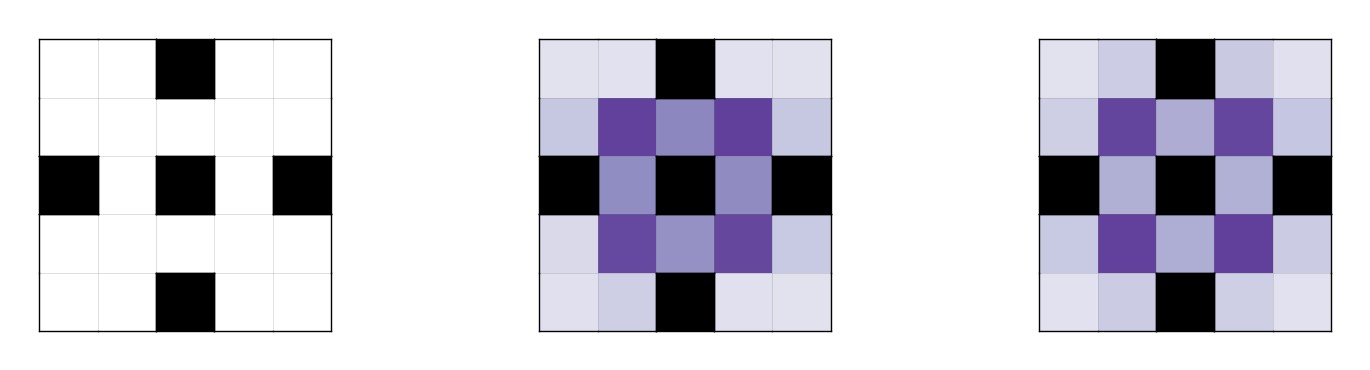

In [8]:
hmap = np.zeros((num_states, num_sims))
for sim in range(num_sims):
    d = np.load('./Data/schapiro/schapiro_%d.npz' % sim)
    replayed_exps = d['replayed_exps']
    for i in range(replayed_exps.shape[0]):
        hmap[replayed_exps[i, 0], sim] += 1

hmap_avg = np.mean(hmap, axis=1)
hmap_avg = hmap_avg.reshape(height, width)

cmap = plt.get_cmap('Purples')
trunc_map = truncate_colormap(cmap, 0.2, 0.8) # plasma 0.15 1.0

fig, axes = get_fixed_size_figax(nrow=1, ncol=3)

# Schematic
ax = axes[0]
ax.set_aspect('equal')
ax.set_axis_off()
gw.draw(use_reachability=True, ax=ax, wall_width=1)

# Asymptotic need
ax = axes[1]
d = np.load('./Data/schapiro/schapiro_0.npz')
meta_need = d['meta_need']
avg_need = np.average(meta_need[-1, :, :], weights=init_state_dist, axis=0)
plot_state_metric(gw, avg_need.reshape(-1), save=False, ax=ax, wall_width=1, custom_cmap=trunc_map)

# Simulated replay distribution
ax = axes[2]
plot_state_metric(gw, hmap_avg.reshape(-1), save=False, ax=ax, wall_width=1, custom_cmap=trunc_map)

# Save
fig.savefig('./figs/Fig2_schapiro.pdf', transparent=True)

*Supp. fig. comparison of need to betweenness-centrality in Schapiro community graph maze*

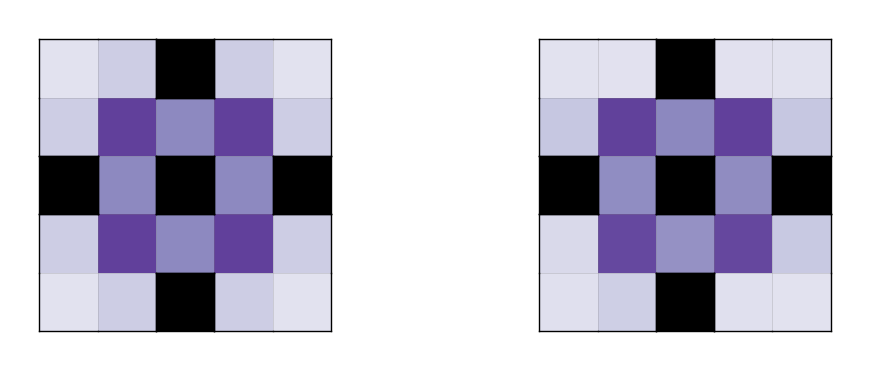

In [10]:
cmap = plt.get_cmap('Purples')
trunc_map = truncate_colormap(cmap, 0.2, 0.8) # plasma 0.15 1.0

fig, axes = get_fixed_size_figax(nrow=1, ncol=2)

# Betweenness centrality
ax = axes[0]
ax.set_aspect('equal')
ax.set_axis_off()

gw_A = gw.generate_adjacency_matrix(allow_self_loops=True, allow_multiloops=True)
for i in range(num_states):
    if i not in valid_states:
        gw_A[i, :] = 0
        
# betweenness centrality
bc = betweenness_centrality(gw_A, convert_unweighted=True)
plot_state_metric(gw, bc, save=False, ax=ax,
                 wall_width=1, custom_cmap=trunc_cividis)

# Asymptotic need
ax = axes[1]
d = np.load('./Data/schapiro/schapiro_0.npz')
meta_need = d['meta_need']
avg_need = np.average(meta_need[-1, :, :], weights=init_state_dist, axis=0)
plot_state_metric(gw, avg_need.reshape(-1), save=False, ax=ax, wall_width=1, custom_cmap=trunc_map)

# Save
fig.savefig('./figs/FigS1_schapiro_need_BC.pdf', transparent=True)